# Preprocessing

Now it's time to clean our data, with the goal of removing noise we don't believe originates from the brain. This may be the part of EEG data analysis with the most researcher-degrees-of-freedom, which is to say that it's ripe with opportunities for reproducibility problems. 

Historically, the gold standard (which isn't much of a "standard" but whatever) has been the identification of artifacts by visual inspection. I concur that there is no substitute for a visual inspection of your data, but my hot take is that, if you can't specify your data cleaning criteria in code, you're probably not using well-defined criteria. A lot of researchers will refer to EEG data cleaning as "more art than science" . . . I don't think I need to point out the problem with _literally accepting that._

Consequently, my preprocessing pipeline (which can vary depending on the particular analysis I intend downstream, so consider this more of a skeleton pipeline) prioritizes **reproducibility**. Another person should be able to run my code and get the same results _exactly_, which is already a huge improvement over most preprocessing pipelines, even if someone doesn't agree with each of my individual steps. (And people who are going to have different preferences re: how to preprocess their data are a dime-a-dozen, so that will certainly happen.)

It also prioritizes **transparency**. Most researchers will report something in their papers along the lines of "trials were rejected based on _x_ criteria, and electrodes' time series were interpolated if they appeared noisy by visual inspection," and if we're lucky, they'll report something like "_y_% of all trials were rejected"  But all that granular information about the data quality of individual subjects, e.g. how many trials and which electrodes were rejected from each indivudally, is lost in the aggregate. For the vast majority of the EEG literature, you just have to trust the authors made reasonable choices on those details, assuming they even have a good record of why decisions were made. 

Of course, we can't fix the arbitrariness of some of our decisions, but we can at least make our pipeline clear and our data quality transparent. So an important part of this script is that it spits out a data quality report into a BIDS derivatives folder (similar to what fMRIPrep does if you're familiar with that), which can be included in the dataset uploaded to OpenNeuro. Then, at least, other researchers can see what decisions we made during preprocessing which may have affected results.

So I don't mean to tell you this is how you should preprocess your data. I make decisions here that are somewhat arbitrary. But my hope is that this provides an example of a relatively transparent preprocessing pipeline, in which all your decisions are encoded to the degree that they can be reproduced exactly. (And, since it's mostly automated, you'll save a ton of time compared to a point-and-click GUI -- just in case you needed an incentive. Though you should still _always_ look at your raw data.)

In [21]:
import numpy as np
import os.path as op
from pprint import pformat
# EEG utilities 
import mne
from mne.preprocessing import ICA, create_eog_epochs
from pyprep.prep_pipeline import PrepPipeline
from autoreject import get_rejection_threshold, validation_curve
# BIDS utilities
from mne_bids import BIDSPath, read_raw_bids
from util.io.bids import DataSink
from bids import BIDSLayout
from bids import BIDSLayout

If you haven't noticed in the other notebooks, I like to put my hard coded variables in a hard-coded block near the top. That way, it's easier to find and modify them later if needed without introducing inconsistencies into our code. Not _everything_ hardcoded gets the honor of being up here, but a few things that are helpful to be able to change quickly.

In [27]:
# constants 
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')

Since our data is in BIDS format, we can easily grab all of our subject and task info without hard-coding anything.

In [28]:
# parse BIDS directory 
layout = BIDSLayout(BIDS_ROOT)
subjects = layout.get_subjects()
tasks = layout.get_tasks()
runs = layout.get_runs()
print(subjects, tasks, runs)

['4', '6', '3', '5', '2'] ['pitch'] [1, 2]


In a real batch preprocessing script, we'd write a loop like `for sub in subjects`, or `for sub_idx, sub in enumerate(subjects)`, but then I can't easily pontificate between blocks of code. So in this notebook, we'll just process one subject. (Of course, we only have one at time of writing, but still).

I'll assign those same variables as if we were nested within a for-loop, to facilitate any copy-and-pasting you want to do later:

In [29]:
sub_idx = 0 # integer index of the subject in subject list
sub = subjects[sub_idx] # subject identifier (in this case a string) 
task = tasks[0]
run = str(runs[0])

MNE-BIDS can handle loading all our BIDS formatted data, including all the sidecar files (like channel information, electrode positions, and metadata). `read_raw_bids` will make sure all that is organized correctly into an `mne.Raw` object.

In [31]:
# grab the EEG data
bids_path = BIDSPath(root = BIDS_ROOT, 
                     subject = sub,
                     task = task,
                     datatype = 'eeg',
                     run = run)
# print(bids_path)
raw = read_raw_bids(bids_path, verbose = False)
raw = raw.pick_types(eeg = True)
events, event_ids = mne.events_from_annotations(raw)

Used Annotations descriptions: ['100', '150', '200', '250', '50']


If we had digitized electrode positions, the BIDS loader would've already added them to `raw`, but we don't. So let's specify a standard montage to use.

In [32]:
dig = mne.channels.make_standard_montage('standard_1020')
raw = raw.set_channel_types({'Aux1': 'stim'})
raw = raw.set_montage(dig)

/var/folders/hv/vj9_d69170l26hyj9hqqj45h0000gn/T/ipykernel_16958/3581454364.py:2: RuntimeWarning: The unit for channel(s) Aux1 has changed from V to NA.
  raw = raw.set_channel_types({'Aux1': 'stim'})


I'm going to make a copy of our raw data before preprocessing, so we can later visualize how preprocessing affected our results.

In [35]:
raw_unprocessed = raw.copy()
raw.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG, 1 Stimulus
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 66 items (3 Cardinal, 63 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 2500.0 Hz
 meas_date: 1924-12-31 10:09:47 UTC
 nchan: 64
 projs: []
 sfreq: 5000.0 Hz
 subject_info: 4 items (dict)
>

If you thought I'd gotten off of my open-science soapbox, you are mistaken. I'm actually going to let another Python package, `pyprep`, handle the first big preprocessing steps. `pyprep` implements the [PREP Pipeline](https://doi.org/10.3389/fninf.2015.00016), an attempt at standarizing some of the less controversial steps in EEG preprocessing, such as re-referencing, notch filtering (which removes power line noise), and identification/interpolation of bad electrode channels. (There is also a [PREP implementation in MATLAB](https://github.com/VisLab/EEG-Clean-Tools) for the EEGLab ecosystem.)

Aside from standardization, there are actually some important issues that PREP addresses. If you re-reference your electrodes to the average of all electrodes (reminder: voltages are only meaningfully quantified relative to other voltages), and there's a noisy electrode, that noise leaks into _all_ the other channels. Moreover, if you re-reference to the average and later interpolate a channel, then your former average is no longer the average -- you've referenced to . . . something else? An artifact? All this sounds like you'd just interpolate bad channels first and then re-reference, but alas, it is not so easy. Turns out the identification of bad channels depends heavily on your current reference. PREP implements a multi-stage procedure, which balances both of these considerations to re-reference and interpolate robustly, hopefully optimizing signal-to-noise. It will also identify bad electrodes for us, and it's actually quite good at it; the last dataset of 20 subjects I analyzed, I only disagreed with it for one out of $20 \times 128 = 2560$ electrodes. That's not too shabby, at least insofar as I'm a good baseline. Anyway, I encourage you to read [the paper](https://doi.org/10.3389/fninf.2015.00016) for more details.

The only real parameter we're specifying is the power line frequencies to notch filter out. A good idea is to do 60 Hz (if you're in the U.S.) and all of its harmonics ($60 \times n$ for integers $n$) up to whatever is the highest frequency we're analyzing; in code, `np.arange(raw.info['line_freq'], LOWPASS, raw.info['line_freq'])`, where `LOWPASS` is the cutoff for our lowpass fitler. (In other words, we plan on removing frequencies higher than `LOWPASS` from the signal later.) Otherwise, you might replace `LOWPASS` with the Nyquist frequency, which is half of your sampling rate -- the highest frequency you _can_ analyze. In our case, `LOWPASS` is lower than the line frequency, but not _that_ much lower, so we still notch at 60 Hz to account for the fact that our filter has a slow roll-off (it doesn't filter perfectly). That's what the `if np.arange(lf, LOWPASS, lf) else [lf]` does.

The other notable things here are that (1) I set the random seed to the subject's integer index. This is to ensure that any steps that involve randomness can always be reproduced exactly without setting the seed the same for each subject. Also, (2) I set `ransac = False`; this is a method for identifying bad electrodes based on cross-validation, the premise being that neighboring electrodes should predict each others' values due to high spatial autocorrelation. This doesn't perform very well with few electrodes, and it arguably requires exact, subject-specific electrode coordinates, so I turned it off since we have a meager 32 electrodes and no true electrode positions.

In [36]:
raw, events = raw.resample(2000, events = events)

In [37]:
# run PREP pipeline (notch, exclude bad chans, and re-reference)
raw.load_data() # read the data into memory
np.random.seed(sub_idx)
raw.load_data()
lf = raw.info['line_freq']
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(lf, LOWPASS, lf) if np.arange(lf, LOWPASS, lf).size > 0 else [lf]
}
prep = PrepPipeline(raw, prep_params, raw.get_montage(), ransac = False, random_state = sub_idx)
prep.fit()

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Removed notch frequencies (Hz):
     60.00 : 12600 windows
    120.00 : 12600 windows
    180.00 : 12600 windows
    239.00 :   63 windows
    240.00 : 12600 windows
    241.00 :   63 

2022-04-06 10:16:19,916 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C1', 'CPz', 'C2'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C2', 'C1', 'CPz']}
2022-04-06 10:17:42,437 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}
2022-04-06 10:17:45,908 - pyprep.reference - INFO - Iterations: 1
2022-04-06 10:18:53,972 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C1', 'C2', 'FC2', 'CPz'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C2', 'C1', 'CPz', 'FC2']}


Interpolating bad channels
    Automatic origin fit: head of radius 91.7 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 4 sensors


2022-04-06 10:18:58,702 - pyprep.reference - INFO - Iterations: 2
2022-04-06 10:20:06,336 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C2', 'C1', 'CPz', 'FC2'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C1', 'C2', 'CPz', 'FC2']}
2022-04-06 10:20:06,337 - pyprep.reference - INFO - Robust reference done


Interpolating bad channels
    Automatic origin fit: head of radius 91.7 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 4 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Found 0 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

0 by correlation: []

0 by SNR: []

0 by dropout: []

0 by RANSAC: []



/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/pyprep/reference.py:154: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 sec)



PREP has multiple means of detecting bad electrodes, and it will tell you why it thought they were bad. Note that one fo these methods is to detect high frequency noise, which is why we haven't applied a lowpass filter yet -- we don't want to remove the high frequency noise until we've used it to detect bad electrodes. 

We can get a cleaned version of the data out of the `prep` object, which has any electrodes that PREP didn't repair marked as bad. We'll replace `raw` with the clean version.

In [38]:
raw = prep.raw_eeg # cleaned data
raw.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 63 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 66 items (3 Cardinal, 63 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 1000.0 Hz
 meas_date: 1924-12-31 10:09:47 UTC
 nchan: 63
 projs: []
 sfreq: 2000.0 Hz
 subject_info: 4 items (dict)
>

Now that we've done that, we can filter the data at our final bandwidth.

In [39]:
# bandpass
raw_for_ica = raw.filter(l_freq = 1., h_freq = 1000)
raw = raw.filter(l_freq = 30, h_freq = 270)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 6601 samples (3.300 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 2.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper 

Now we're going to re-reference some electrodes around the eyes to create a virtual EOG (electrooculogram) channel, which will measure the movement of the eyes. We'll use this shortly as a means of identifying eye contamination in the remaining EEG electrodes. (Note that it's usually helpful to put some electrodes on the face to get a better EOG recording, but just taking the voltage difference between EEG electrodes on either side of the eyes works well in a pinch.)

In [40]:
# create virtual EOG channels from two electrodes across the eyes from one another 
raw_for_ica = mne.set_bipolar_reference(raw_for_ica, anode = 'Fp1', cathode = 'FT10', ch_name = 'eog1', drop_refs = False)
raw_for_ica = mne.set_bipolar_reference(raw_for_ica, anode = 'Fp2', cathode = 'FT9', ch_name = 'eog2', drop_refs = False)
raw_for_ica = raw_for_ica.set_channel_types({'eog1': 'eog', 'eog2': 'eog'})

raw = mne.set_bipolar_reference(raw, anode = 'Fp1', cathode = 'FT10', ch_name = 'eog1', drop_refs = False)
raw = mne.set_bipolar_reference(raw, anode = 'Fp2', cathode = 'FT9', ch_name = 'eog2', drop_refs = False)
raw = raw.set_channel_types({'eog1': 'eog', 'eog2': 'eog'})

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2018500
    Range : 0 ... 2018499 =      0.000 ...  1009.250 secs
Ready.
Added the following bipolar channels:
eog1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2018500
    Range : 0 ... 2018499 =      0.000 ...  1009.250 secs
Ready.
Added the following bipolar channels:
eog2
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2018500
    Range : 0 ... 2018499 =      0.000 ...  1009.250 secs
Ready.
Added the following bipolar channels:
eog1
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=2018500
    Range : 0 ... 2018499 =      0.000 ...  1009.250 secs
Ready.
Added the following bipolar channels:
eog2


Now, we will segment the data into trials. Since we've filtered high frequencies out of our data, there's no reason to keep our sampling rate as high as it is, so we're going to downsample our data. But it's critical to downsample __after__ segmenting the data into epochs, since downsampling can add jitter to our event triggers (since you might remove the sample on which the trigger was recorded.)

In [41]:
# segment and then downsample
epochs_for_ica = mne.Epochs(
    raw_for_ica, 
    events, 
    tmin = -0.2, 
    tmax = 0.250, 
    baseline = None, # do NOT baseline correct the trials yet; we do that after ICA
    event_id = event_ids, # remember which epochs are associated with which condition
    preload = True # keep data in memory
)

epochs = mne.Epochs(
    raw, 
    events, 
    tmin = -0.2, 
    tmax = 0.250, 
    baseline = None, # do NOT baseline correct the trials yet; we do that after ICA
    event_id = event_ids, # remember which epochs are associated with which condition
    preload = True # keep data in memory
)

Not setting metadata
Not setting metadata
2461 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2461 events and 901 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
2461 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2461 events and 901 original time points ...
0 bad epochs dropped


Now is a good time to do artifact _correction_ via Independent Components Analysis (ICA), in which we try to seperate our data into statistically independent parts, after which we can remove those compenents we don't think think come from the brain (e.g. originate from the eyes). This is an example of [blind source separation](https://en.wikipedia.org/wiki/Signal_separation).

I am doing this _after_ segmenting into epochs, since ICA will try to prioritize the signal sources that explain the most variance. In many recordings, subjects will be moving around a lot at the beginning and end or between trials, and we wouldn't want to "waste" ICA components on data we weren't going to analyze to begin with. 

Another note: ICA performs poorly in the presence of low frequency drift, so you should high pass filter _before_ computing independent components. However, you should _not_ baseline correct (subtract out the mean of a baseline period for each electrode at the beginning of each trial) before ICA, since it might break a relationship between electrodes across trials. 

In [42]:
# compute ICA components on a copy of the data
ica = ICA(n_components = 15, random_state = 0)
ica.fit(epochs_for_ica, picks = 'eeg')

Fitting ICA to data using 63 channels (please be patient, this may take a while)


/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Selecting by number: 15 components
Fitting ICA took 35.9s.


Method,fastica
Fit,19 iterations on epochs (2217361 samples)
ICA components,15
Explained variance,64.5 %
Available PCA components,63
Channel types,eeg
ICA components marked for exclusion,—


We can easily plot the included components.

/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(li

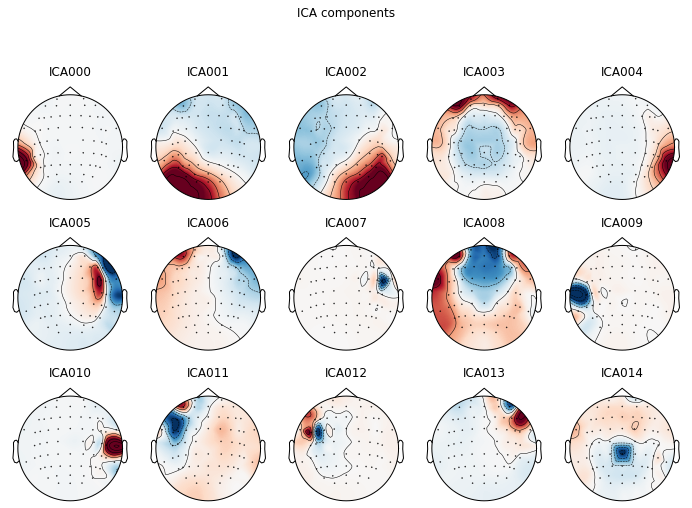

In [43]:
fig_ica = ica.plot_components()

Now, let's remove those components that are most correlated with eye movements.

Using EOG channels: eog1, eog2
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 63 PCA components


/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/Users/nusbaumlab/opt/anaconda3/envs/pitch-tracking/lib/python3.10/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(li

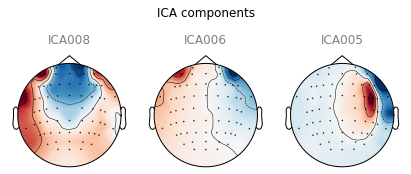

In [44]:
# and exclude ICA components that are correlated with EOG
eog_indices, eog_scores = ica.find_bads_eog(epochs_for_ica, threshold = 1.96)
ica.exclude = eog_indices
ica.apply(epochs) # transforms in place

if ica.exclude: # if we found any bad components
    fig_ica_removed = ica.plot_components(ica.exclude)

In [47]:
epochs.get_channel_types()

['eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eog',
 'eog']

That should remove the ICAs that are most correlated with the EOG electrodes from the signal. Huzzah. Now that that's done, we can apply baseline correction, which we definitely want to do if we're interested in an evoked response. This will ensure that the electrode voltages of each trial start in vaguely the same place, so we're really looking at a _relative_ change in the voltages subsequent to the onset of the stimulus, which is what we're really interested in. (Unless you're a motor control person like me, in which case the activity _before_ the movement/stimulus is what you're interested in. Or if you're interested in expectations or preparedness. None of these are hard-and-fast rules.)

In [59]:
# apply baseline correction *AFTER* ICA
epochs = epochs.pick_types(eeg=True)
epochs = epochs.apply_baseline((-.2, 0.))

Applying baseline correction (mode: mean)


Even after all of our effort, not all the gross, non-brain stuff will usually have been satisfactorily removed from the signal, so we'll still need to reject trials to exceed some threshold of noisiness. This is usually a positive-peak-to-negative-peak amplitude threshold. Often, researchers will arbitrarily pick a threshold before preprocessing, or they'll tweak their threshold until their trial survival count looks acceptable. In the interest of mitigating arbitrariness, we'll again offload to package, `autoreject`, which will find the rejection threshold that minimizes cross-validated difference between each trial and the average of the other trials. (By default, it uses 5-fold cross-validation.) This is meant to be a proxy for maximizing signal-to-noise, or the topographic consistency between trials. As a result, we're going to end up with a different threshold for each subject (which is generally fine, since each subject's brain/scalp/skull is, in fact, different), so it's important we record this information for posterity. 

In [50]:
# and then reject bad trials
thres = get_rejection_threshold(epochs) # finds optimal threshold 
print(thres) # peak-to-peak rejection threshold in microvolts

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog
{'eeg': 6.248362840898811e-05, 'eog': 4.441940716610302e-05}


In [55]:
epochs = epochs.drop_bad(reject = {'eeg': 50e-6}) # 50 microvolts, use custom threshold this time

ValueError: reject["eeg"] == 5e-05 > 3e-05 (old value), new reject values must be at least as stringent as previous ones

Now for the big reveal! The evoked response, or event-related potential (ERP), is just the average of all the surviving preprocessed trials. (We're plotting both conditions together below, but we'll talk about comparing conditions in another tutorial.)

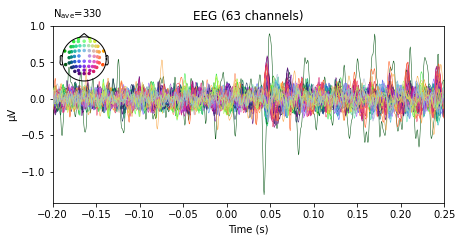

In [57]:
fig_erp = epochs['50'].average().plot(spatial_colors = True)

Not bad for a single subject, with not _too_ many trials to boot.

I wonder how it would look without preprocessing . . . 

Not setting metadata
Not setting metadata
2461 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2461 events and 5001 original time points ...
0 bad epochs dropped


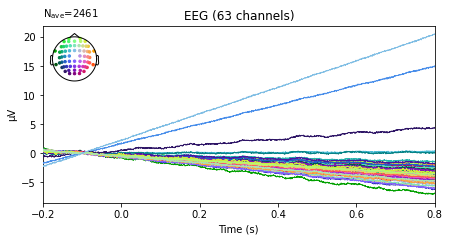

In [53]:
# segment and then downsample
epochs_unprocessed = mne.Epochs(
    raw_unprocessed, 
    events, 
    tmin = -0.2, 
    tmax = 0.8, 
    baseline = (-0.2, 0.0), # baseline correct to be fair
    event_id = event_ids,
    preload = True
)
bad_fig = epochs_unprocessed.average().plot(spatial_colors = True)

So yeah, that's why we preprocess our data.

Time to save our preprocessed data to use later. MNE-BIDS isn't (yet) so great with derivative files, so I made a little `DataSink` utility, which lives in the `util` folder, to save processed data in a BIDS-compliant manner.It creates the necessary BIDS derivatives directory structure, and then provides a filepath to save your data at.

In [57]:
sink = DataSink(DERIV_ROOT, 'preprocessing')

# save cleaned data
fpath = sink.get_path(
                subject = sub,
                task = task, 
                desc = 'clean',
                suffix = 'epo', # this suffix is following MNE, not BIDS, naming conventions
                extension = 'fif.gz',
                )
epochs.save(fpath, overwrite = True)

Overwriting existing file.


Remember when I said we would produce a quality check report? Now is the time to make good on that. This will produce an `.html` in the `derivatives/preprocessing` directory with some details about what we did here (which channels we interpolated and why, which ICAs we removed, etc.) and an image of the average ERP to facilitate quality check. This is both useful for you (you have all this information for your records, and can use it for a quick quality check) and for other people, who can see _exactly_ what e.g. ICAs you removed, rather than taking your word for it.

In [58]:
# generate a report
report = mne.Report(verbose = True)
report.parse_folder(op.dirname(fpath), pattern = '*epo.fif.gz', render_bem = False)
report.add_figs_to_section(
    fig_erp, 
    captions = 'Average Evoked Response', 
    section = 'evoked'
)
if ica.exclude:
    report.add_figs_to_section(
        fig_ica_removed, 
        captions = 'Removed ICA Components', 
        section = 'ICA'
    ) 
bads = prep.noisy_channels_original
html_lines = []
for line in pformat(bads).splitlines():
    html_lines.append('<br/>%s' % line) 
html = '\n'.join(html_lines)
report.add_htmls_to_section(html, captions = 'Interpolated Channels', section = 'channels')
report.add_htmls_to_section('<br/>threshold: {:0.2f} microvolts</br>'.format(thres['eeg'] * 1e6), 
                            captions = 'Trial Rejection Criteria', section = 'rejection')
report.add_htmls_to_section(epochs.info._repr_html_(), captions = 'Info', section = 'info')
report.save(op.join(sink.deriv_root, 'sub-%s.html'%sub), overwrite = True)

Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Iterating over 1 potential files (this may take some 
Rendering : /Users/nusbaumlab/src/pitch_tracking/bids_data/derivatives/preprocessing/sub-1/sub-1_task-pitches_desc-clean_epo.fif.gz
Reading /Users/nusbaumlab/src/pitch_tracking/bids_data/derivatives/preprocessing/sub-1/sub-1_task-pitches_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1050 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1050 events and 451 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Overwriting existing file.
Saving report to : /Users/nusbaumlab/src/pitch_tracking/bids_data/derivatives/preprocess

'/Users/nusbaumlab/src/pitch_tracking/bids_data/derivatives/preprocessing/sub-1.html'

Now we've added our cleaned data to a new `derivatives` subfolder of our BIDS formated dataset, as well as a quality check report in `sub-Pablo.html`. The directory structure now looks as follows:

In [59]:
from mne_bids import print_dir_tree
print_dir_tree(BIDS_ROOT)

|bids_data/
|--- .DS_Store
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- derivatives/
|------ preprocessing/
|--------- dataset_description.json
|--------- sub-1.html
|--------- sub-1/
|------------ sub-1_task-pitches_desc-clean_epo.fif.gz
|--- sub-1/
|------ .DS_Store
|------ sub-1_scans.tsv
|------ eeg/
|--------- sub-1_task-pitches_channels.tsv
|--------- sub-1_task-pitches_eeg.eeg
|--------- sub-1_task-pitches_eeg.json
|--------- sub-1_task-pitches_eeg.vhdr
|--------- sub-1_task-pitches_eeg.vmrk
|--------- sub-1_task-pitches_events.tsv
